In [1]:
import numpy as np


def get_square_sample(lat_start, lon_start, segment_len=64, num_segments=4):
    lat_end = lat_start + num_segments * segment_len * 0.05 
    lon_end = lon_start + num_segments * segment_len * 0.05
    assert lat_end < 90, f"lat_end {lat_end} must be less than 90"
    assert 0 <= lon_end <= 360, f"lon_end {lon_end} must be between 0 and 360"
    
    sample_lats = np.arange(lat_start, lat_end, 0.05)
    sample_lons = np.arange(lon_start, lon_end, 0.05)

    assert len(sample_lats) % segment_len == 0, f"Sample lats and lons must be divisible by segment_len: {segment_len}, {len(sample_lats)}"
    assert len(sample_lons) % segment_len == 0, f"Sample lats and lons must be divisible by segment_len: {segment_len}, {len(sample_lons)}"
    
    return sample_lats, sample_lons

def segment_sample(data, orientation, segment_len=64, with_roll=False):
    height, width, num_cols = data.shape
    if orientation == 'vertical':
        data = np.transpose(data, (1, 0, 2))
    # random roll in first two dimensions
    if with_roll:
        data = np.roll(data, np.random.randint(-5, 5), axis=(0, 1))
    segments = np.zeros((height*width // segment_len, num_cols, segment_len), dtype=np.float32)
    for i in range(num_cols):
        segments[:, i, :] = data[:, :, i].reshape(height*width // segment_len, segment_len)
    return segments

from fco2dataset.ucollocate import get_day_data, collocate
def get_day_dataset(date):
    # get global satellite data for a given date
    dss = get_day_data(date, save_path='../data/inference/gridded')
    return dss

def collocate_coords(df, dss, date):
    save_path = '../data/inference/collocated'
    df_collocated = collocate(df, date, save_path=save_path, dss=dss, verbose=False)
    return df_collocated

def normalize(df, stats, mode):
    for i in range(1, len(stats['means'])): # first column is the target
        col = df.columns[i - 1]
        # print(f"Normalizing {col} with {mode}")
        if mode == 'min_max':
            # print(f"Min: {stats['mins'][i]}, Max: {stats['maxs'][i]}")
            df[col] = 2 * (df[col] - stats['mins'][i]) / (stats['maxs'][i] - stats['mins'][i]) - 1
        elif mode == 'mean_std':
            df[col] = (df[col] - stats['means'][i]) / stats['stds'][i]
        else:
            raise ValueError(f"Unknown mode {mode}")
    return df

In [2]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch


def denoise2d_squares(model, noise_scheduler, params, date, jump=20):
     dss = get_day_dataset(date) # datsets lon range 0, 360
     starts = [(-20, 250)] * 1
    #  for i in range(1, 5):
    #      # perturb the start coordinates randomly
    #         starts[i] = (starts[i-1][0] + np.random.randint(-10, 10), starts[i-1][1] + np.random.randint(-10, 10))
     samples = []
     for start in starts:
         print(f"Starting denoising for {start}")
         sample = denoise2d_square(model, noise_scheduler, params, date, dss, start, jump=jump)
         samples.append(sample)
     return samples

def merge_squares(starts):
    all_lats = []
    all_lons = []
    meshgrids = []
    for lat, lon in starts:
        lats, lons = get_square_sample(lat, lon, segment_len=64, num_segments=5)
        np.meshgrid(lats, lons)
        meshgrids.append(np.meshgrid(lons, lats))
        all_lats.append(lats)
        all_lons.append(lons)
        print(f"bounds for start {lat, lon}: {lats.min()}, {lats.max()}, {lons.min()}, {lons.max()}")
    all_lats = np.concatenate(all_lats)
    all_lons = np.concatenate(all_lons)
    meshgrids = np.concatenate(meshgrids, axis=2)
    return all_lats, all_lons, meshgrids

from fco2models.utraining import prep_df
def denoise2d_square(model, noise_scheduler, params, date, dss, starts, jump=20, box=None):
    """full denoising loop for a 2d image for diffusion model"""
    predictors = params['predictors']
    stats = {
    'means':params['train_means'],
    'stds':params['train_stds'],
    'mins':params['train_mins'],
    'maxs':params['train_maxs']
    }
    # lats, lons = get_square_sample(starts[0], starts[1], segment_len=64, num_segments=5)
    # print(f"min lat: {lats.min()}, max lat: {lats.max()}")
    # print(f"min lon: {lons.min()}, max lon: {lons.max()}")
    # lon_coords, lat_coords = np.meshgrid(lons, lats)
    # height, width = lats.size, lons.size

    # sample = np.random.randn(height, width)
    # sample_df = pd.DataFrame(
    #     sample.flatten(), 
    #     index=pd.MultiIndex.from_product([lats, lons]), 
    #     columns=['sample']
    #     )
    
    
    # sample_df.index.set_names(['lat', 'lon'], inplace=True)
    lats, lons, coords = merge_squares(starts)
    lon_coords, lat_coords = coords
    print(lats.shape, lons.shape, coords.shape)
    # coords = np.meshgrid(lats, lons)
    height, width = coords.shape[1], coords.shape[2]
    sample = np.random.randn(height, width)
    sample_df = pd.DataFrame(
        sample.flatten(),
        index=pd.MultiIndex.from_arrays([coords[1].flatten(), coords[0].flatten()]),
        columns=['sample']
    )
    sample_df.index.set_names(['lat', 'lon'], inplace=True)

    dss = get_day_dataset(date) # datasets lon range 0, 360
    context_df = collocate_coords(sample_df, dss, date=date)

    # move lons in range -180, 180
    context_df['lon'] = (context_df['lon'] + 180) % 360 - 180
    context_df['time_1d'] = date
    context_df = prep_df(context_df, with_target=False)[0][predictors]

    # impute nans with mean of column
    # context_df = context_df.fillna(context_df.mean()) # only for testing
    # print(context_df.isna().sum())

    context_df = normalize(context_df, stats, 'min_max')
    #print(context_df.max(), context_df.min())
    # count nans percentage in context_df per column
    # for col in context_df.columns:
    #     print(f"Number of nans in {col}: {np.isnan(context_df[col]).sum() / context_df.shape[0] * 100:.2f}%")
    
    context_ds = np.zeros((height, width, len(predictors)))#context_df[predictors].values.reshape(lats.size, lons.size, len(predictors))
    for i, col in enumerate(predictors):
        context_ds[:, :, i] = context_df[col].values.reshape(height, width) # seems a little safer than just reshaping
    
    sample_col = sample[:, :, np.newaxis]
    sample_context_ds = np.concatenate([sample_col, context_ds, np.ones_like(sample_col)], axis=2)
    #print(sample_context_ds[0, :, 0:2])

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    #print(f"Inference on {device}")
    model.to(device)
    step = 0
    t_loop = tqdm(noise_scheduler.timesteps[::jump], desc="Denoising steps")
    for t in t_loop:
        if step % 2 == 0:
            segments = segment_sample(sample_context_ds.copy(), 'horizontal', segment_len=64)
        else:
            segments = segment_sample(sample_context_ds.copy(), 'vertical', segment_len=64)

        ds = torch.from_numpy(segments).to(device).float()
        #print(f"ds shape: {ds.shape}")
        dataloader = torch.utils.data.DataLoader(ds, batch_size=64, shuffle=False)
        samples = []
        for (ix, batch) in enumerate(dataloader):
            with torch.no_grad():
                batch = batch.to(device)
                #context = batch[:, 1:, :].to(device)
                sample_prev = batch[:, 0:1, :].to(device)
                noise_pred = model(batch, t, return_dict=False)[0]
                x_0 = noise_scheduler.step(noise_pred, t, sample_prev).pred_original_sample
                if t - jump > 0:
                    sample = noise_scheduler.add_noise(x_0, torch.randn_like(sample_prev), t - jump)
                else:
                    sample = x_0
                sample[torch.isnan(sample)] = sample_prev[torch.isnan(sample)]
                samples.append(sample.cpu().numpy())
            t_loop.set_postfix({"batch":{ix}})
        
        samples = np.concatenate(samples, axis=0)
        if step % 2 == 0:
            samples = samples.reshape(height, width, 1)
        else:
            samples = samples.reshape(width, height).T[:, :, np.newaxis]
        #print(f"Samples shape: {samples.shape}")
        sample_context_ds = np.concatenate([samples, context_ds, np.ones_like(sample_col)], axis=2)
        step += 1
        # count nans percentage in the sample array
        #print(f"Number of nans in the sample array: {np.isnan(samples).sum() / samples.size * 100:.2f}%")
        #print(f"Step {step} done")
    return np.concatenate([sample_context_ds, lat_coords[:,:, np.newaxis], lon_coords[:,:, np.newaxis]], axis=2)

In [3]:
from fco2models.models import UNet2DModelWrapper, UNet1DModel
from fco2models.ueval import load_model
import torch
# load baseline model
save_path = '../models/constlr/pointpos/'
model_path = 'e_100.pt'
model_class = UNet2DModelWrapper
model, noise_scheduler, params, losses = load_model(save_path, model_path, model_class)
print("model loaded")

model loaded


In [4]:
# import model and noise scheduler
from fco2models.models import UNet2DModelWrapper
from diffusers import DDPMScheduler
noise_scheduler = DDPMScheduler(num_train_timesteps=1000, clip_sample_range=2.0)
date = pd.Timestamp('2022-10-04')
stats = {
    'means':params['train_means'],
    'stds':params['train_stds'],
    'mins':params['train_mins'],
    'maxs':params['train_maxs']
}

In [5]:
starts = [(-20, 250)]
dss = None#get_day_dataset(date) # datasets lon range 0, 360
sample_context_dss_list = denoise2d_square(model, noise_scheduler, params, dss=dss, starts=starts, date=date)

bounds for start (-20, 250): -20.0, -4.049999999999773, 250.0, 265.9500000000036
(320,) (320,) (2, 320, 320)
All files reachable for date 2022-10-04 00:00:00
globcolour data already exists at ../data/inference/gridded_2022-10-04/globcolour.nc
soda data already exists at ../data/inference/gridded_2022-10-04/soda.nc
cmems data already exists at ../data/inference/gridded_2022-10-04/cmems.nc
sss_cci data already exists at ../data/inference/gridded_2022-10-04/sss_cci.nc
sss_multiobs data already exists at ../data/inference/gridded_2022-10-04/sss_multiobs.nc
sst_cci data already exists at ../data/inference/gridded_2022-10-04/sst_cci.nc
Reading globcolour data from ../data/inference/gridded_2022-10-04/globcolour.nc
Reading soda data from ../data/inference/gridded_2022-10-04/soda.nc
Reading cmems data from ../data/inference/gridded_2022-10-04/cmems.nc
Reading sss_cci data from ../data/inference/gridded_2022-10-04/sss_cci.nc
Reading sss_multiobs data from ../data/inference/gridded_2022-10-04/ss

2025-05-22 12:37:29,879 - INFO - salinity stacking
2025-05-22 12:37:29,880 - INFO - adding positional and temporal encodings
2025-05-22 12:37:29,903 - INFO - add climatology data
Denoising steps:   0%|          | 0/50 [00:00<?, ?it/s]

: 

In [6]:
# sample_context_dss = np.concatenate(sample_context_dss_list, axis=0)
sample_context_dss = sample_context_dss_list
lats = sample_context_dss[:, :, -2]
lons = sample_context_dss[:, :, -1]
lons = (lons + 180) % 360 - 180
preds = sample_context_dss[:, :, 0]
lats_quantized = np.round(lats * 100).astype(int)
lons_quantized = np.round(lons * 100).astype(int)
ds_pred = pd.DataFrame(
    preds.flatten(), 
    index=pd.MultiIndex.from_arrays([lats_quantized.flatten(), lons_quantized.flatten()]), 
    columns=['sample'])
ds_pred.index.set_names(['lat', 'lon'], inplace=True)

ds_pred_mean = ds_pred.groupby(['lat', 'lon']).mean()
ds_pred_std = ds_pred.groupby(['lat', 'lon']).std()

ds_pred_mean = ds_pred_mean.reset_index()
ds_pred_std = ds_pred_std.reset_index()
ds_pred_mean['lat'] = ds_pred_mean['lat'] / 100
ds_pred_mean['lon'] = ds_pred_mean['lon'] / 100
ds_pred_std['lat'] = ds_pred_std['lat'] / 100
ds_pred_std['lon'] = ds_pred_std['lon'] / 100
ds_pred_mean.set_index(['lat', 'lon'], inplace=True)
ds_pred_std.set_index(['lat', 'lon'], inplace=True)


ds_pred_mean = ds_pred_mean.to_xarray()
ds_pred_std = ds_pred_std.to_xarray()

In [7]:
ds_pred_mean

<xarray.Dataset> Size: 824kB
Dimensions:  (lat: 320, lon: 320)
Coordinates:
  * lat      (lat) float64 3kB -20.0 -19.95 -19.9 -19.85 ... -4.15 -4.1 -4.05
  * lon      (lon) float64 3kB -110.0 -110.0 -109.9 ... -94.15 -94.1 -94.05
Data variables:
    sample   (lat, lon) float64 819kB -0.1078 -0.08448 -0.1461 ... 0.3785 0.296

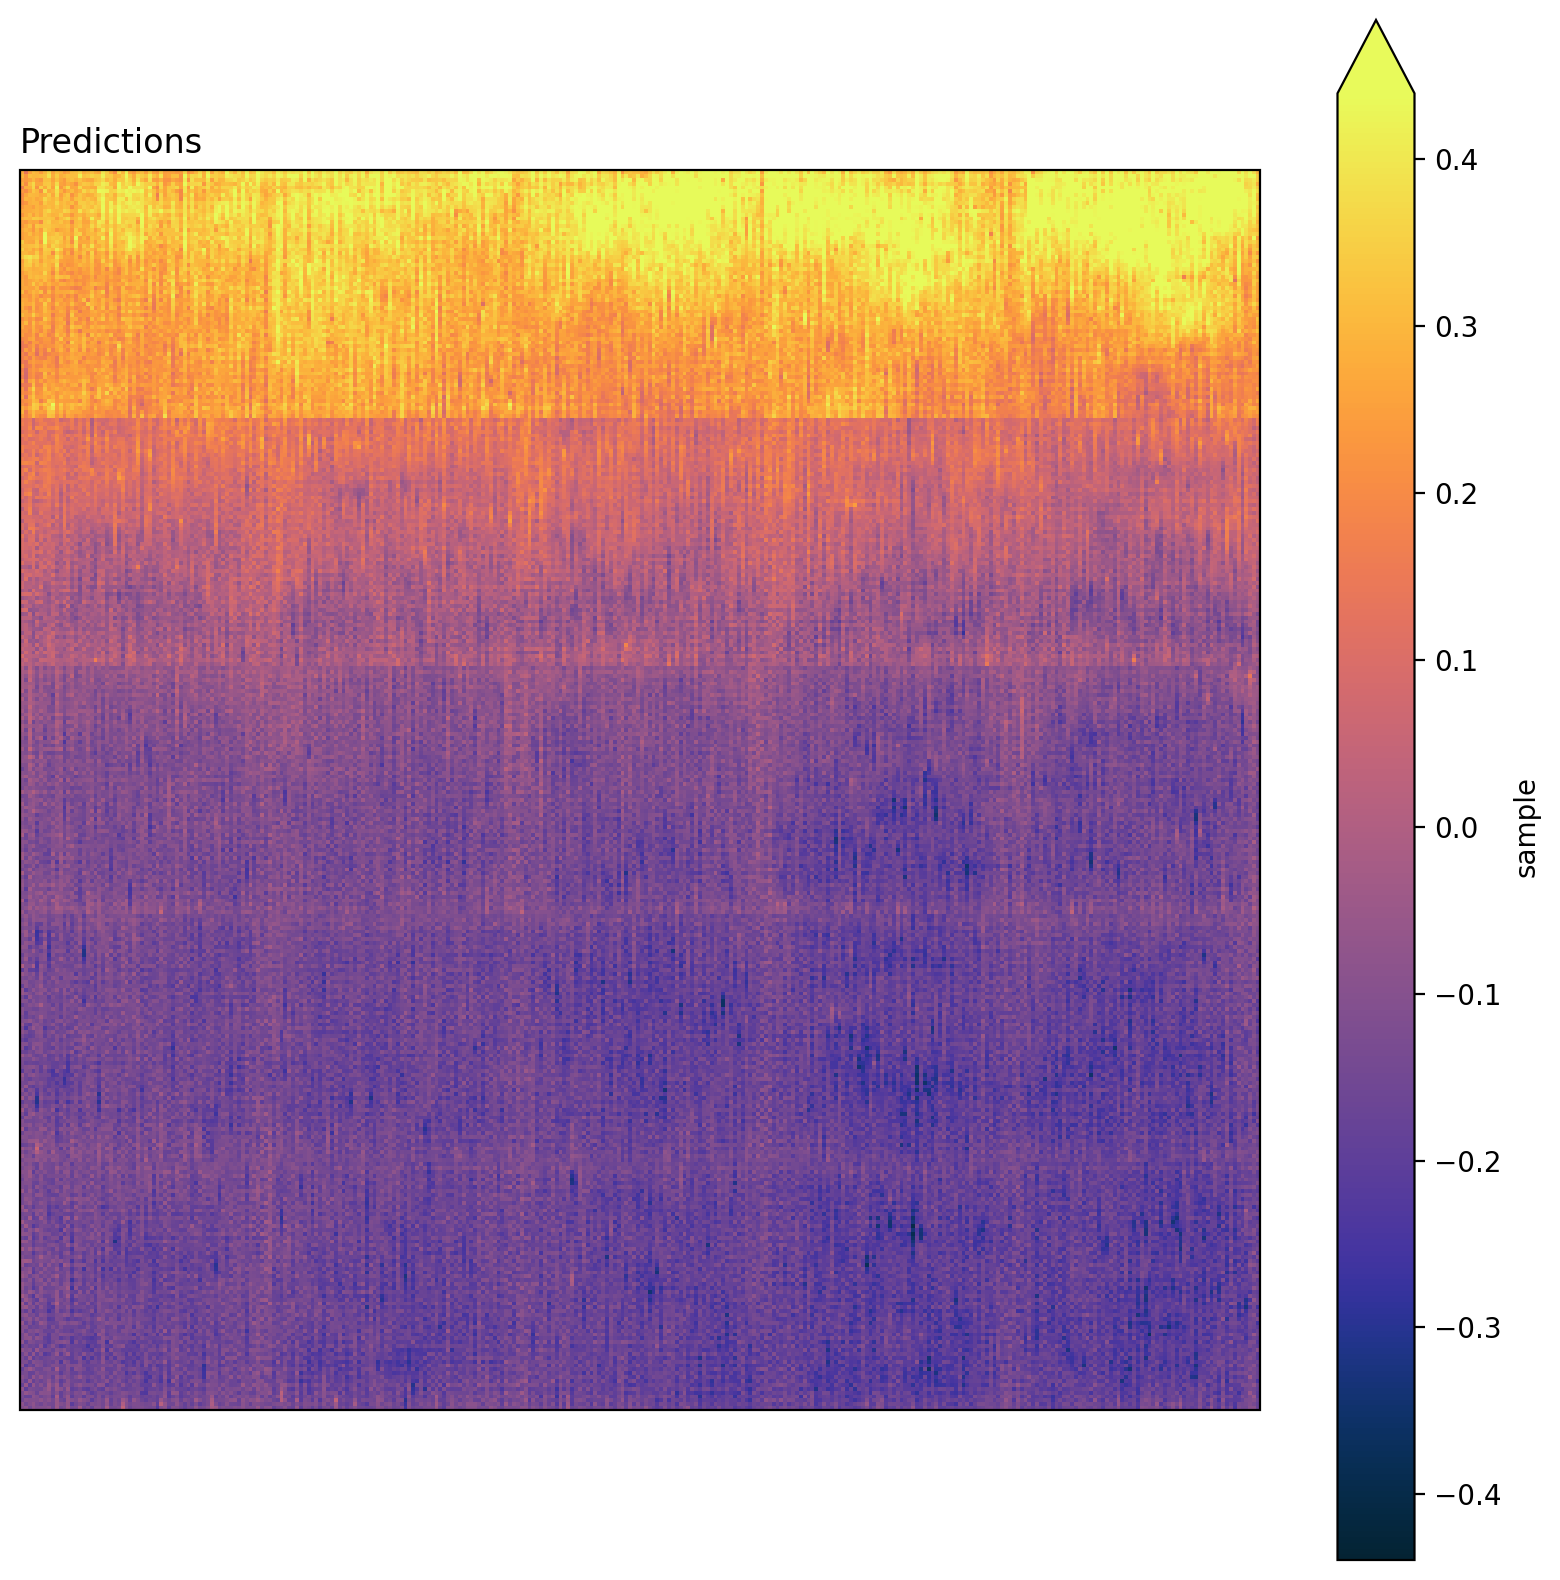

In [10]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cmocean import cm as cmo  # registers the cmocean colormaps to matplotlib
fig = plt.figure(figsize=(10, 10), dpi=200)
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
# ax.set_global()
ax.add_feature(cfeature.LAND, zorder=1, edgecolor='black', facecolor='lightgrey')
ax.add_feature(cfeature.COASTLINE, zorder=2, edgecolor='black')

ax.set_title('Predictions', fontsize=12, loc='left')

# plot data with meshgrid
# mesh = ax.pcolormesh(da.lon, da.lat, da, cmap=cmo.thermal, shading='auto',
#                      transform=ccrs.PlateCarree(), zorder=5)
def move_lon(lon):
        """move lon from 0-360 to -180, 180"""
        lon = (lon + 180) % 360 - 180
        return lon
(ds_pred_mean
 #.sel(lat=slice(0, 15), lon=slice(move_lon(30), move_lon(46)))
 .sample
 .plot
 .imshow(cmap='cmo.thermal', 
         ax=ax, add_colorbar=True, 
         transform=ccrs.PlateCarree(), 
         robust=True,
         ))

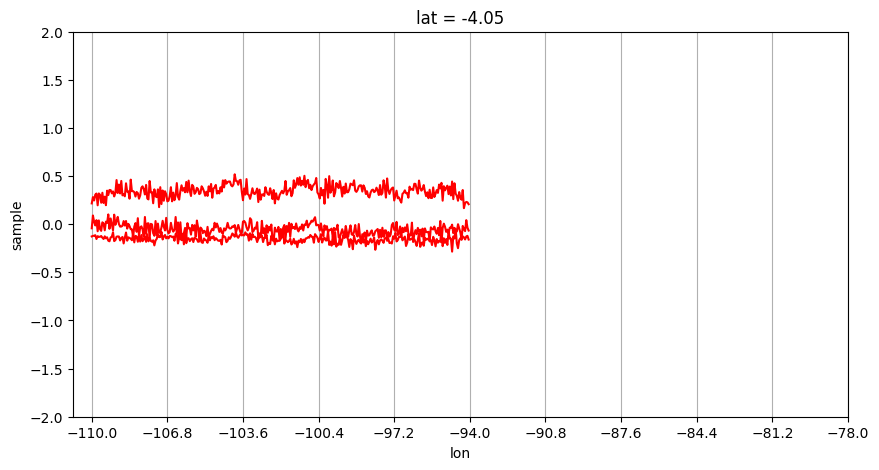

In [181]:
fig, ax = plt.subplots(figsize=(10, 5), dpi=100)
ylims = (-2, 2)
ds_pred_mean.sample.sel(lat=-20, method='nearest').plot(ax=ax, color='red', label='sample', ylim=ylims)
ds_pred_mean.sample.sel(lat=-10, method='nearest').plot(ax=ax, color='red', label='sample', ylim=ylims)
ds_pred_mean.sample.sel(lat=0, method='nearest').plot(ax=ax, color='red', label='sample', ylim=ylims)
to_range = lambda lon: (lon + 180) % 360 - 180
ax.grid(axis='x')
ax.set_xticks(np.arange(to_range(250.0), to_range(285), 0.05*64))
plt.show()

In [19]:
ds_pred.max(), ds_pred.min()

(sample    0.671737
 dtype: float64,
 sample   -0.489114
 dtype: float64)

In [ ]:
def plot_satmap(da): 
    fig, ax = plt.subplots(
    figsize=(9, 5), 
    subplot_kw=dict(
        projection=ccrs.EqualEarth()  # the map projection we want to use
    ), 
    dpi=100)

    img = (
        da
        .plot.contour(  # the xarray.DataArray matplotlib API has [imshow, pcolormesh, contour, contourf] methods
            ax=ax,  # plot on the axis we created
            transform=ccrs.PlateCarree(),  # required to transform the data to the map projection (always PlateCarree)
            cmap='Spectral_r',
            levels=20,  # create discrete colorbar (not the same as contourf)
            center=False,  # if true, the colormap is centered on zero
            cbar_kwargs=dict(  # colorbar keyword arguments
                # label='Custom label for SLA [m]',  # we can set the label, but by default will use `da.attrs.long_name [da.attrs.units]` 
                location='bottom', 
                shrink=0.5,  # reduce the colorbar size to fit our plot
                pad=0.05),
            robust=True,  # this will set the colormap limits to the 2nd and 98th percentiles
        )
    )
    
    ax.coastlines(lw=1)  # axes with cartopy projection have a coastlines method
    ax.add_feature(cfeature.BORDERS.with_scale('110m'), edgecolor='0.8', linewidth=0.3)
    ax.set_title(f'fco2 reconstruction', loc='left', fontsize=12)
    
    fig.tight_layout()
    plt.show()

plot_satmap(ds_pred_mean.sample)

KeyboardInterrupt: 

In [142]:
lats.shape

(1600, 640)

In [180]:
predictors = params['predictors']

In [181]:
dss = get_day_dataset(date)
stats = {
    'means':params['train_means'],
    'stds':params['train_stds'],
    'mins':params['train_mins'],
    'maxs':params['train_maxs']
}

sample = np.random.randn(lats.size)
sample_df = pd.DataFrame(
    sample.flatten(), 
    index=pd.MultiIndex.from_arrays([lats.flatten(), (lons.flatten() + 360) % 360]), 
    columns=['sample']
    )
sample_df.index.set_names(['lat', 'lon'], inplace=True)
context_df = collocate_coords(sample_df, dss, date=date)
# impute nans with mean of column
# move lons in range -180, 180
context_df['lon'] = (context_df['lon'] + 180) % 360 - 180
context_df['time_1d'] = date
context_df = prep_df(context_df, with_target=False)[0][predictors]
# impute nans with mean of column
context_df = context_df.fillna(context_df.mean()) # only for testing
context_df = normalize(context_df, stats, 'min_max')

All files reachable for date 2022-10-04 00:00:00
globcolour data already exists at ../data/inference/gridded_2022-10-04/globcolour.nc
soda data already exists at ../data/inference/gridded_2022-10-04/soda.nc
cmems data already exists at ../data/inference/gridded_2022-10-04/cmems.nc
sss_cci data already exists at ../data/inference/gridded_2022-10-04/sss_cci.nc
sss_multiobs data already exists at ../data/inference/gridded_2022-10-04/sss_multiobs.nc
sst_cci data already exists at ../data/inference/gridded_2022-10-04/sst_cci.nc
Reading globcolour data from ../data/inference/gridded_2022-10-04/globcolour.nc
Reading soda data from ../data/inference/gridded_2022-10-04/soda.nc
Reading cmems data from ../data/inference/gridded_2022-10-04/cmems.nc
Reading sss_cci data from ../data/inference/gridded_2022-10-04/sss_cci.nc
Reading sss_multiobs data from ../data/inference/gridded_2022-10-04/sss_multiobs.nc
Reading sst_cci data from ../data/inference/gridded_2022-10-04/sst_cci.nc


2025-05-14 12:43:37,908 - INFO - salinity stacking
2025-05-14 12:43:37,917 - INFO - adding positional and temporal encodings
2025-05-14 12:43:38,172 - INFO - add climatology data


In [182]:
context_df.mean()

sst_cci            0.260460
sss_cci            0.767667
chl_globcolour    -0.995905
ssh_sla            0.079121
mld_dens_soda     -0.939138
xco2               0.883031
co2_clim8d         0.435471
sin_day_of_year    0.379447
cos_day_of_year   -0.726602
sin_lat           -0.216645
sin_lon_cos_lat   -0.959887
cos_lon_cos_lat    0.067543
dtype: float64

In [184]:

context_ds = np.zeros((lats.shape[0], lats.shape[1], len(predictors)), dtype=np.float32)#context_df[predictors].values.reshape(lats.size, lons.size, len(predictors))
for i, col in enumerate(predictors):
    context_ds[:, :, i] = context_df[col].values.reshape(lats.shape[0], lats.shape[1]) # seems a little safer than just reshaping
segments = segment_sample(context_ds.copy(), 'horizontal', segment_len=64)

In [188]:
segments[100, 1, :]

array([0.8197105 , 0.8197105 , 0.8197105 , 0.8197105 , 0.8197105 ,
       0.81862295, 0.81862295, 0.81862295, 0.81862295, 0.81862295,
       0.81582785, 0.81582785, 0.81582785, 0.81582785, 0.81582785,
       0.8138908 , 0.8138908 , 0.8138908 , 0.8138908 , 0.8138908 ,
       0.8151326 , 0.8151326 , 0.8151326 , 0.8151326 , 0.8151326 ,
       0.81248534, 0.81248534, 0.81248534, 0.81248534, 0.81248534,
       0.8198724 , 0.8198724 , 0.8198724 , 0.8198724 , 0.8198724 ,
       0.81285644, 0.81285644, 0.81285644, 0.81285644, 0.81285644,
       0.81375   , 0.81375   , 0.81375   , 0.81375   , 0.81375   ,
       0.80586123, 0.80586123, 0.80586123, 0.80586123, 0.80586123,
       0.8101531 , 0.8101531 , 0.8101531 , 0.8101531 , 0.8101531 ,
       0.803285  , 0.803285  , 0.803285  , 0.803285  , 0.803285  ,
       0.81295955, 0.81295955, 0.81295955, 0.81295955], dtype=float32)